<a href="https://colab.research.google.com/github/AnyiChomtin/FlightDelayProphet/blob/main/Flight_Delay_Prophet_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialization

In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/ieor 142 final project/Flight Delay/Transformed Data'

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
new_path = '/content/drive/My Drive/ieor 142 final project/Flight Delay/Transformed Data'
os.chdir(new_path)

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Feature Selection

# Modeling Data

## 1. Data Preparation:
* In the preceding notebook, we conducted EDA and
  performed data pre-processing tasks. This notebook is dedicated to the modeling process. To begin, we will import the data that was saved in the previous notebook.

## 2. Loading Data:
* Let's start by reading the data that we prepared and stored in the other   notebook.



In [ ]:
merged_data_cleaned = pd.read_csv('/content/drive/My Drive/ieor 142 final project/Flight Delay/Transformed Data/Bay_Area_Flights_feature_merged.csv')

In [ ]:
merged_data_cleaned.columns

Index(['DayOfWeek', 'Date', 'DepTime', 'ArrTime', 'CRSArrTime',
       'UniqueCarrier', 'Airline', 'FlightNum', 'TailNum', 'ActualElapsedTime',
       'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Origin',
       'Org_Airport', 'Dest', 'Dest_Airport', 'Distance', 'TaxiIn', 'TaxiOut',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay', 'DepHour', 'Month',
       'Same_Day_Num_Flights_of_this_Plane', 'TotalDelay',
       'Plane_Same_Day_Most_Recent_Flight_ArrDelay',
       'Plane_Same_Day_Most_Recent_Flight_DepDelay',
       'Plane_Same_Day_Most_Recent_Flight_TotalDelay',
       'Cumulative_ArrDelay_Before', 'Cumulative_DepDelay_Before',
       'Cumulative_ArrDep_Delay_Before',
       'Cumulative_ArrDelay_Before_Same_Airline',
       'Cumulative_DepDelay_Before_Same_Airline',
       'Cumulative_ArrDep_Delay_Before_Same_Airline', 'Flights_Before',
       'Flights_Before_Same_Airline', 'Avg_ArrDelay_Before',
       'Avg_DepDelay_Before', 

# Feature Processing

## 1. Identifying Features to Remove:
* Now, we need to remove some features from our dataset that may no longer be useful for our model.

## 2. Criteria for Removal:
* For example, features like 'TaxiIn' and 'TaxiOut' might exhibit high correlations with delays. However, since our goal is to predict departure delays, and the 'TaxiIn' and 'TaxiOut' values are only available after boarding, they wouldn't realistically aid travelers in predicting delays.

## 3. Removal Process:
* We'll remove features related to cumulative delays since they may have high correlations with average previous delays and the hour of the day. This could lead to severe multicollinearity issues for linear regression.


In [ ]:
modeling_data = merged_data_cleaned.copy()
columns_to_remove = ['Date', 'DepTime', 'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum', 'CRSElapsedTime', 'Org_Airport',
                     'ArrDelay', 'Dest', 'Dest_Airport', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
                     'Cumulative_ArrDep_Delay_Before', 'Cumulative_ArrDelay_Before_Same_Airline', 'Cumulative_DepDelay_Before_Same_Airline',
                     'Cumulative_ArrDep_Delay_Before_Same_Airline', 'Cumulative_DepDelay_Before', 'Cumulative_ArrDelay_Before', 'TaxiIn', 'TaxiOut',
                     'ActualElapsedTime']
modeling_data.drop(columns=columns_to_remove, inplace=True)
print(modeling_data.shape)
print(modeling_data.head())

(23506, 27)
  DayOfWeek                 Airline  AirTime  DepDelay Origin  Distance  \
0   Tuesday   United Air Lines Inc.      269        48    OAK      2408   
1   Tuesday   United Air Lines Inc.      216        19    OAK      1835   
2   Tuesday  Southwest Airlines Co.       57        22    OAK       337   
3   Tuesday    Alaska Airlines Inc.       76        59    OAK       543   
4   Tuesday  Southwest Airlines Co.       65        25    OAK       371   

   DepHour  Month  Same_Day_Num_Flights_of_this_Plane  TotalDelay  ...  \
0        0      1                                   1          79  ...   
1        6      1                                   1          35  ...   
2        8      1                                   2          40  ...   
3        8      1                                   1         109  ...   
4        9      1                                   2          49  ...   

   Avg_ArrDelay_Before_Same_Airline  Avg_DepDelay_Before_Same_Airline  \
0                  


# Outlier Removal

## 1. Identifying Outliers:
* Later in our analysis, we will inspect scatter plots to identify outliers.

## 2. Code Addition for Improved Visualization:
* We include the code to remove outliers here since it can help improve the scaling of the plot axes.


In [ ]:
def remove_top_outliers(data, num_outliers=5):
    for column in data.select_dtypes(include=['float64', 'int64']).columns:
        largest_values = data[column].nlargest(num_outliers).index
        data = data.drop(index=largest_values)
    return data

modeling_data_less_outliers = remove_top_outliers(modeling_data.copy(), num_outliers=10)
print(modeling_data_less_outliers.shape)

(23266, 27)


# Visualizing Feature Distribution

## 1. Selecting the Y Variable
* Our Y variable of interest is departure delay (**"DepDelay"**).

## 2. Visualizing Distribution
* We will create scatter plots to visualize the distribution between departure delay (**"DepDelay"**) and each feature.


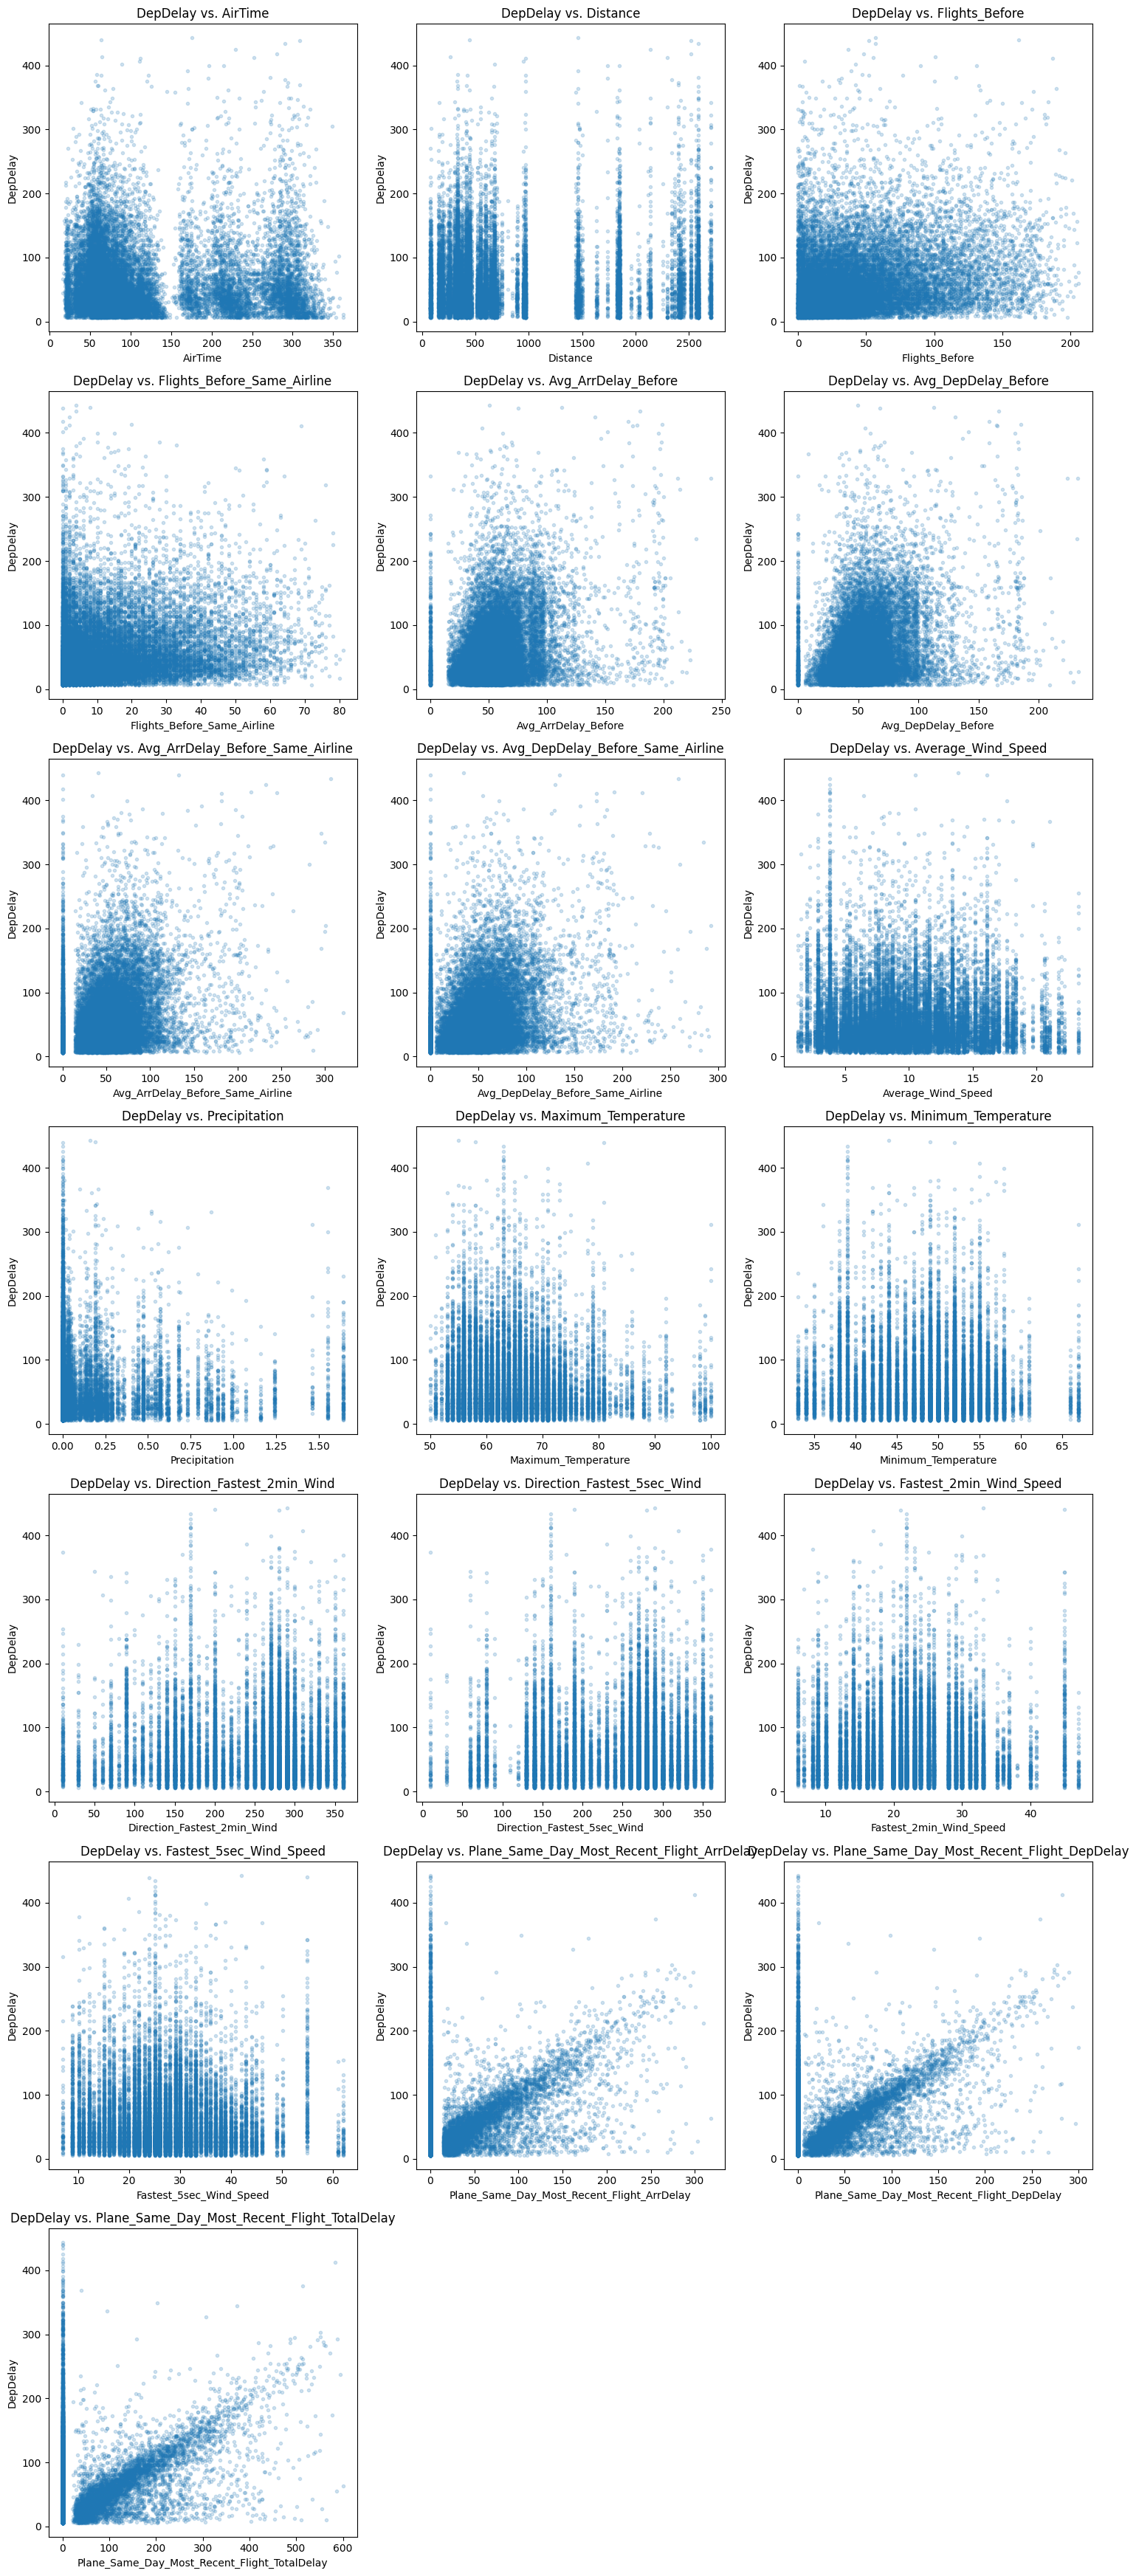

In [ ]:
import math

numeric_features = [
    'AirTime', 'Distance', 'Flights_Before', 'Flights_Before_Same_Airline',
    'Avg_ArrDelay_Before', 'Avg_DepDelay_Before', 'Avg_ArrDelay_Before_Same_Airline',
    'Avg_DepDelay_Before_Same_Airline', 'Average_Wind_Speed', 'Precipitation',
    'Maximum_Temperature', 'Minimum_Temperature', 'Direction_Fastest_2min_Wind',
    'Direction_Fastest_5sec_Wind', 'Fastest_2min_Wind_Speed', 'Fastest_5sec_Wind_Speed',
    'Plane_Same_Day_Most_Recent_Flight_ArrDelay', 'Plane_Same_Day_Most_Recent_Flight_DepDelay',
    'Plane_Same_Day_Most_Recent_Flight_TotalDelay'
]

num_features = len(numeric_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, num_rows * 5))
axes = axes.ravel()

for idx, feature in enumerate(numeric_features):
    axes[idx].scatter(modeling_data_less_outliers[feature], modeling_data_less_outliers['DepDelay'], alpha=0.2, marker='.')
    axes[idx].set_title(f'DepDelay vs. {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('DepDelay')

for idx in range(len(numeric_features), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Identifying and Removing Zero-Value Features

## 1. Observing Plots
* From the plots, we notice that certain features have numerous zero values.

## 2. Removing Zero Values
* Upon inspection, we conclude that these zero values can be considered outliers as they lack real meaning and distort the trend significantly, then they would be removed.


In [ ]:
def remove_zero_outliers(data, features):
    for feature in features:
        data = data[data[feature] != 0]
    return data

flight_features = ['AirTime', 'Distance', 'Flights_Before', 'Flights_Before_Same_Airline',
                    'Avg_ArrDelay_Before', 'Avg_DepDelay_Before',
                    'Avg_ArrDelay_Before_Same_Airline', 'Avg_DepDelay_Before_Same_Airline']

modeling_data_less_outliers = remove_zero_outliers(modeling_data_less_outliers, flight_features)
print(modeling_data_less_outliers.shape)

(20259, 27)



# Handling Missing Values

* Before regression, we need to make sure no more missing values exist



In [ ]:
nan_counts = modeling_data_less_outliers.isna().sum()
print(nan_counts)

DayOfWeek                                       0
Airline                                         0
AirTime                                         0
DepDelay                                        0
Origin                                          0
Distance                                        0
DepHour                                         0
Month                                           0
Same_Day_Num_Flights_of_this_Plane              0
TotalDelay                                      0
Plane_Same_Day_Most_Recent_Flight_ArrDelay      0
Plane_Same_Day_Most_Recent_Flight_DepDelay      0
Plane_Same_Day_Most_Recent_Flight_TotalDelay    0
Flights_Before                                  0
Flights_Before_Same_Airline                     0
Avg_ArrDelay_Before                             0
Avg_DepDelay_Before                             0
Avg_ArrDelay_Before_Same_Airline                0
Avg_DepDelay_Before_Same_Airline                0
Average_Wind_Speed                              0


# Creating Dummy Variables for Categorical Features

## 1. Identification of Categorical Features
* Identify the categorical features in the dataset that need to be converted into dummy variables.

## 2. Dummy Variable Creation
 * Using the `pd.get_dummies()` function, we will create dummy variables for these categorical features.




In [ ]:
categorical_features = ['DayOfWeek', 'Airline', 'Origin', 'DepHour', 'Month']
modeling_data = pd.get_dummies(modeling_data_less_outliers, columns=categorical_features)
print(modeling_data.shape)
print(modeling_data.head())

(20259, 71)
   AirTime  DepDelay  Distance  Same_Day_Num_Flights_of_this_Plane  \
1      216        19      1835                                   1   
4       65        25       371                                   2   
5       64        25       407                                   2   
6      220        16      1844                                   2   
7       90        10       671                                   3   

   TotalDelay  Plane_Same_Day_Most_Recent_Flight_ArrDelay  \
1          35                                         0.0   
4          49                                         0.0   
5          44                                         0.0   
6          39                                         0.0   
7          31                                        87.0   

   Plane_Same_Day_Most_Recent_Flight_DepDelay  \
1                                         0.0   
4                                         0.0   
5                                         0.0   
6   

## Splitting Data into Training, Validation, and Test Sets


In [ ]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(modeling_data, test_size=0.4, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Training Set Shape:", train_data.shape)
print("Validation Set Shape:", validation_data.shape)
print("Test Set Shape:", test_data.shape)

Training Set Shape: (12155, 71)
Validation Set Shape: (4052, 71)
Test Set Shape: (4052, 71)


# Checking Correlation between Y Variable and Features


In [ ]:
correlation_matrix = train_data.corr()
dep_delay_correlations = correlation_matrix['DepDelay']
dep_delay_correlations.sort_values(ascending=False)

pd.set_option('display.max_rows', None)
print(dep_delay_correlations.sort_values(ascending=False))
pd.reset_option('display.max_rows')

DepDelay                                        1.000000
TotalDelay                                      0.992432
Avg_DepDelay_Before                             0.345164
Avg_ArrDelay_Before                             0.338409
Avg_ArrDelay_Before_Same_Airline                0.336526
Avg_DepDelay_Before_Same_Airline                0.335940
Flights_Before                                  0.294110
Plane_Same_Day_Most_Recent_Flight_DepDelay      0.288523
Plane_Same_Day_Most_Recent_Flight_TotalDelay    0.288033
Plane_Same_Day_Most_Recent_Flight_ArrDelay      0.285426
Flights_Before_Same_Airline                     0.193946
Origin_SFO                                      0.175389
Same_Day_Num_Flights_of_this_Plane              0.140925
Month_1                                         0.128800
DepHour_0                                       0.088616
DepHour_1                                       0.086447
DepHour_23                                      0.078319
Airline_American Airlines Inc. 

## Addressing Potential Multi-collinearity

### 1. Pre-Modeling Check
* Before proceeding with modeling, we need to address potential multicollinearity issues as they can impact the interpretability of our model.

### 2. Checking VIF
* We will calculate the Variance Inflation Factor (VIF) for each feature.

### 3. Note on Dummy Variables
* We will not account for the VIFs for the dummy variables here. Typically, dummy variables have high VIFs due to their correlation structure, and it's not a usual practice to assess multicollinearity for them.


In [ ]:
train_data.drop(['TotalDelay'], axis=1, inplace=True)
validation_data.drop(['TotalDelay'], axis=1, inplace=True)
test_data.drop(['TotalDelay'], axis=1, inplace=True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

X_numeric = train_data[numeric_features]
X_numeric = add_constant(X_numeric)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
pd.set_option('display.max_rows', None)
print(vif_data)


## Iterative Removal of Features with High VIF

### 1. Initial VIF Check
* We will start by checking the VIF for each feature.

### 2. Removal Process
* For features with high VIFs that we are less interested in, we will iteratively remove them and check VIF again.

### 3. Repeat Until VIFs Drop Below Threshold
* We will repeat the removal process until all VIFs drop to below 5, indicating acceptable levels of multicollinearity.


In [ ]:
vif_kept_features = numeric_features.copy()
vif_kept_features.remove('Plane_Same_Day_Most_Recent_Flight_TotalDelay')
vif_kept_features.remove('Plane_Same_Day_Most_Recent_Flight_ArrDelay')
vif_kept_features.remove('Fastest_5sec_Wind_Speed')
vif_kept_features.remove('Direction_Fastest_2min_Wind')
vif_kept_features.remove('Fastest_2min_Wind_Speed')
vif_kept_features.remove('Avg_ArrDelay_Before')
vif_kept_features.remove('AirTime')
vif_kept_features.remove('Avg_ArrDelay_Before_Same_Airline')

removed_features_due_to_vif = [
    'Plane_Same_Day_Most_Recent_Flight_TotalDelay',
    'Plane_Same_Day_Most_Recent_Flight_ArrDelay',
    'Fastest_5sec_Wind_Speed',
    'Direction_Fastest_2min_Wind',
    'Fastest_2min_Wind_Speed',
    'Avg_ArrDelay_Before',
    'AirTime',
    'Avg_ArrDelay_Before_Same_Airline'
]

In [ ]:
X_numeric = train_data[vif_kept_features]
X_numeric = add_constant(X_numeric)
vif_data = pd.DataFrame()
vif_data['Feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X_numeric.shape[1])]
pd.set_option('display.max_rows', None)
print(vif_data)


## Removing Unnecessary Features
* We will identify the features that we do not need from the train, validation, and test datasets, and remove these features from all datasets.



In [ ]:
train_data.drop(columns=removed_features_due_to_vif, inplace=True)
validation_data.drop(columns=removed_features_due_to_vif, inplace=True)
test_data.drop(columns=removed_features_due_to_vif, inplace=True)
print(train_data.head())

Now our data is ready for modeling. Let's move on.

### Linear Regression Modeling

1. **Prepare Data:**
- Continuous adjustments to data types and constants are added to fit the model.

2. **Model Fitting:**
- A linear regression model is fitted using the OLS method from the statsmodels library. The summary provides detailed statistics about the model's performance and the significance of features.

In [ ]:
for column in train_data.columns:
    train_data[column] = pd.to_numeric(train_data[column], errors='coerce')

bool_columns = train_data.select_dtypes(include=['bool']).columns
train_data[bool_columns] = train_data[bool_columns].astype(int)
print(train_data.dtypes)

In [ ]:
import statsmodels.api as sm

columns_to_drop = ['DayOfWeek_Monday', 'Airline_Delta Air Lines Inc.', 'Origin_OAK', 'DepHour_0', 'Month_1']
X_train_lin_reg = train_data.drop(['DepDelay'] + columns_to_drop, axis=1)
X_train_lin_reg = sm.add_constant(X_train_lin_reg)
y_train_lin_reg = train_data['DepDelay']

model = sm.OLS(y_train_lin_reg, X_train_lin_reg).fit()
print(model.summary())

### Regression Tree

1. **Tree Model Fitting:**
- A decision tree for regression is fitted. Parameters are tuned using GridSearchCV, which systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.

2. **Model Evaluation:**
- The performance of the tree model is evaluated using the validation set
- Metrics like R-squared and MAE are calculated.

Best ccp_alpha: 0.009899999999999999
Best estimator: DecisionTreeRegressor(ccp_alpha=0.009899999999999999, random_state=0)


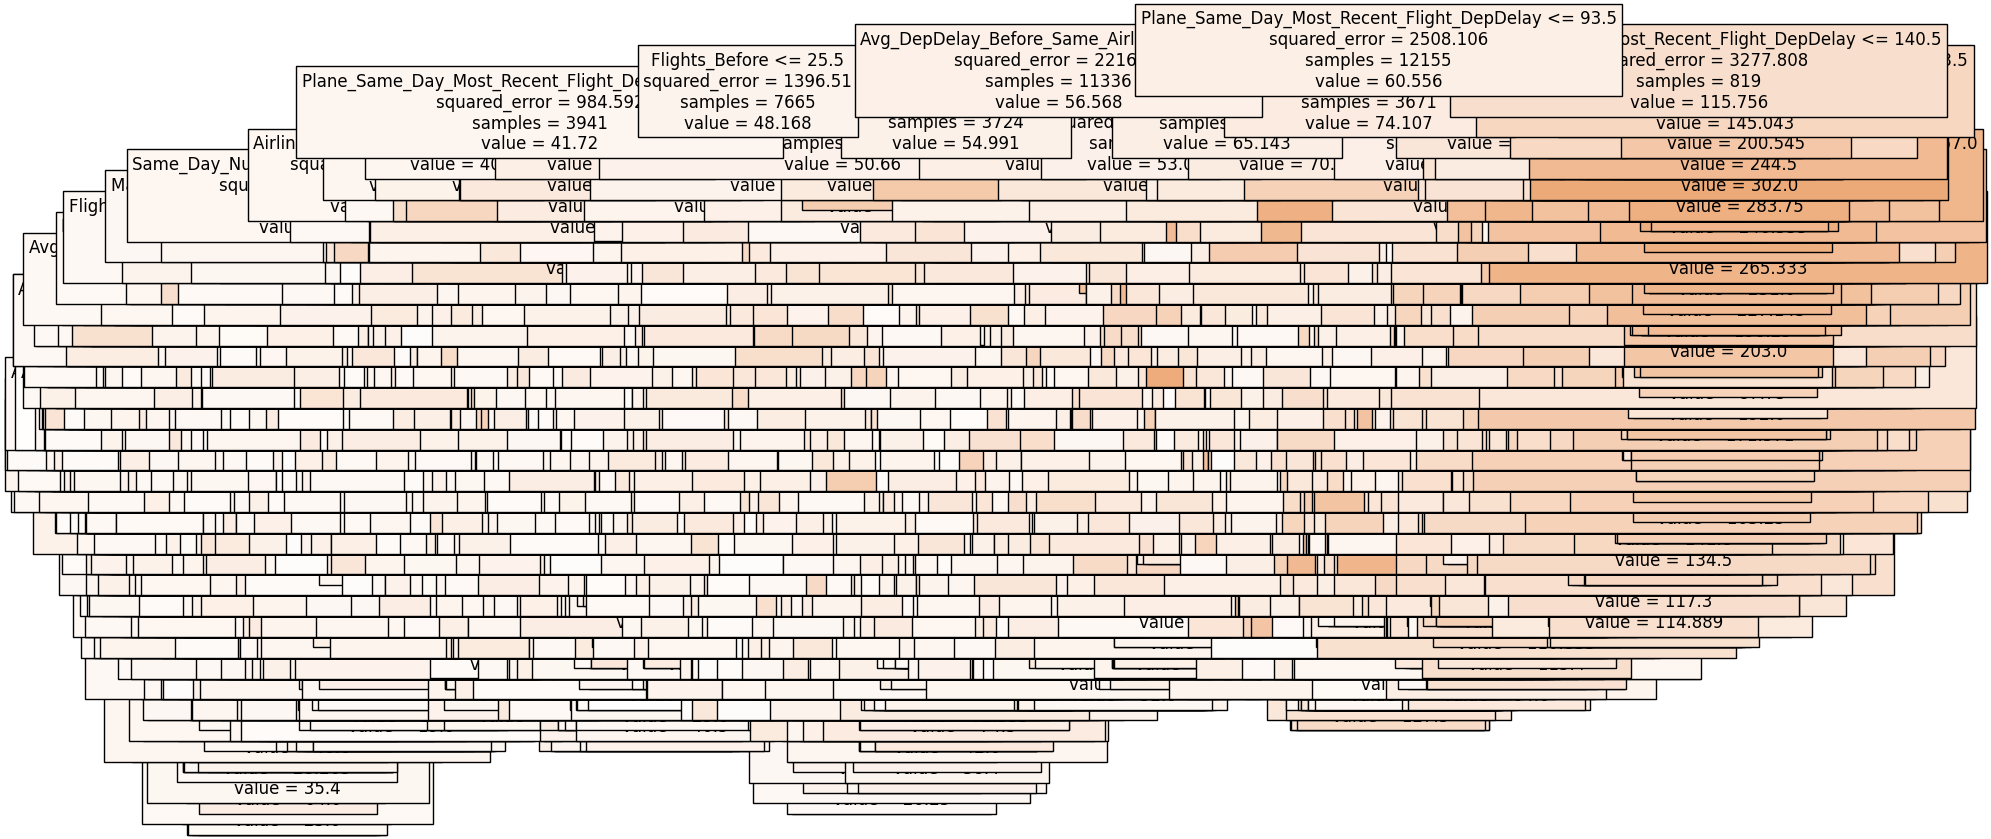

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV

X_train_reg_tree = train_data.drop('DepDelay', axis=1)
y_train_reg_tree = train_data['DepDelay']

tree_model = DecisionTreeRegressor(random_state=0)
param_grid = {'ccp_alpha': np.linspace(0.0001, 0.01, 100)}
grid_search = GridSearchCV(estimator=tree_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_reg_tree, y_train_reg_tree)

print("Best ccp_alpha:", grid_search.best_params_['ccp_alpha'])
print("Best estimator:", grid_search.best_estimator_)
feature_names = X_train_reg_tree.columns
plt.figure(figsize=(20, 10))
plot_tree(grid_search.best_estimator_, filled=True, feature_names=feature_names, fontsize=12)
plt.show()

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error

X_val_reg_tree = validation_data.drop(['DepDelay'], axis=1)
y_val_reg_tree = validation_data['DepDelay']
tree_predictions = grid_search.best_estimator_.predict(X_val_reg_tree)
tree_OSR2 = r2_score(y_val_reg_tree, tree_predictions)
tree_MAE = mean_absolute_error(y_val_reg_tree, tree_predictions)
print(f"Decision Tree OSR2 (using the original feature data): {tree_OSR2:.4f}")
print(f"Decision Tree MAE (using the original feature data): {tree_MAE:.4f}")

### Switching to Classification Problem

Since the regression output is not ideal, let's switch gear a bit to predict whether a flight would be significant delay (more than an hour). This might still be useful as travels can plan their time arriving at the airport more wisely.

1. **Logistic Regression:**

- Given suboptimal regression results, a shift to classification is made to predict whether a delay is significant. Logistic regression is applied, and performance metrics such as accuracy, precision, recall, and F1 score are evaluated.

2. **Classification Tree:**
- A decision tree classifier is trained, and performance metrics are again calculated to evaluate its efficacy in predicting significant delays.

3. **Testing:**
- The trained classification model is tested with the test dataset to assess its performance in a real-world scenario, aiming to provide reliable predictions on flight delays.

### Logistic Regression

In [ ]:
train_data['Significant_DepDelay'] = (train_data['DepDelay'] >= 60).astype(int)
validation_data['Significant_DepDelay'] = (validation_data['DepDelay'] >= 60).astype(int)
test_data['Significant_DepDelay'] = (test_data['DepDelay'] >= 60).astype(int)

In [ ]:
X_train_log_reg = X_train_lin_reg.copy()
y_train_log_reg = train_data['Significant_DepDelay']
model = sm.Logit(y_train_log_reg, X_train_log_reg)
result = model.fit_regularized(method='l1', alpha=0.01)
print(result.summary())

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

X_val_log_reg = validation_data.drop(['DepDelay', 'Significant_DepDelay'] + columns_to_drop, axis=1)
X_val_log_reg = sm.add_constant(X_val_log_reg)
y_val_log_reg = validation_data['Significant_DepDelay']
X_val_log_reg.fillna(0, inplace=True)
X_val_log_reg = X_val_log_reg.astype(float)

val_predictions_log_reg = result.predict(X_val_log_reg) > 0.5
accuracy_log_reg = accuracy_score(y_val_log_reg, val_predictions_log_reg)
precision_log_reg = precision_score(y_val_log_reg, val_predictions_log_reg)
recall_log_reg = recall_score(y_val_log_reg, val_predictions_log_reg)
f1_log_reg = f1_score(y_val_log_reg, val_predictions_log_reg)
conf_matrix_log_reg = confusion_matrix(y_val_log_reg, val_predictions_log_reg)

print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1 Score: {f1_log_reg:.4f}")
print("Confusion Matrix:")
print(conf_matrix_log_reg)

### Classification Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

X_train_class_tree = train_data.drop(['DepDelay', 'Significant_DepDelay'], axis=1)
y_train_class_tree = train_data['Significant_DepDelay']

class_tree_model = DecisionTreeClassifier(random_state=0)
param_grid = {'ccp_alpha': np.linspace(0.0001, 0.01, 100)}
grid_search_class_tree = GridSearchCV(estimator=class_tree_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search_class_tree.fit(X_train_class_tree, y_train_class_tree)

print("Best ccp_alpha:", grid_search_class_tree.best_params_['ccp_alpha'])
print("Best estimator:", grid_search_class_tree.best_estimator_)

feature_names = X_train_class_tree.columns
plt.figure(figsize=(20, 10))
plot_tree(grid_search_class_tree.best_estimator_, filled=True, feature_names=feature_names, fontsize=12)
plt.show()

In [ ]:
X_val_class_tree = X_val_reg_tree.drop('Significant_DepDelay', axis=1)
y_val_class_tree = validation_data['Significant_DepDelay']
class_tree_predictions = grid_search_class_tree.best_estimator_.predict(X_val_class_tree)

accuracy_class_tree = accuracy_score(y_val_class_tree, class_tree_predictions)
precision_class_tree = precision_score(y_val_class_tree, class_tree_predictions)
recall_class_tree = recall_score(y_val_class_tree, class_tree_predictions)
f1_class_tree = f1_score(y_val_class_tree, class_tree_predictions)
conf_matrix_class_tree = confusion_matrix(y_val_class_tree, class_tree_predictions)

print(f"Accuracy: {accuracy_class_tree:.4f}")
print(f"Precision: {precision_class_tree:.4f}")
print(f"Recall: {recall_class_tree:.4f}")
print(f"F1 Score: {f1_class_tree:.4f}")
print("Confusion Matrix:")
print(conf_matrix_class_tree)

In [ ]:
X_test_class_tree = test_data.drop(['DepDelay', 'Significant_DepDelay'], axis=1)
y_test_class_tree = test_data['Significant_DepDelay']

test_tree_predictions = grid_search_class_tree.best_estimator_.predict(X_test_class_tree)

accuracy_test_tree = accuracy_score(y_test_class_tree, test_tree_predictions)
precision_test_tree = precision_score(y_test_class_tree, test_tree_predictions)
recall_test_tree = recall_score(y_test_class_tree, test_tree_predictions)
f1_test_tree = f1_score(y_test_class_tree, test_tree_predictions)
conf_matrix_test_tree = confusion_matrix(y_test_class_tree, test_tree_predictions)

print(f"Accuracy: {accuracy_test_tree:.4f}")
print(f"Precision: {precision_test_tree:.4f}")
print(f"Recall: {recall_test_tree:.4f}")
print(f"F1 Score: {f1_test_tree:.4f}")
print("Confusion Matrix:")
print(conf_matrix_test_tree)

# Random Forest

In [ ]:
modeling_data.head()

X = pd.get_dummies(modeling_data.drop(['DepDelay'], axis=1))
y = modeling_data['DepDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold


grid_values = {'ccp_alpha': np.linspace(0, 0.001, 51)}

dtr = DecisionTreeRegressor(min_samples_leaf=5, min_samples_split=20, random_state=88)


cv = KFold(n_splits=5,random_state=1,shuffle=True)

dtr_cv = GridSearchCV(dtr, param_grid=grid_values, scoring='r2', cv=cv, verbose=0)
dtr_cv.fit(X_train, y_train)


In [ ]:
ccp_alpha = dtr_cv.cv_results_['param_ccp_alpha'].data
R2_scores = dtr_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('ccp_alpha', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(ccp_alpha, R2_scores, s=30)
plt.plot(ccp_alpha, R2_scores, linewidth=3)
plt.grid(True, which='both')

plt.tight_layout()
plt.show()
print('Best ccp_alpha', dtr_cv.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=5, min_samples_leaf=5,
                           n_estimators = 500, random_state=88, verbose=2)

rf.fit(X_train, y_train)


In [ ]:
def OSR2(model, X_test, y_test, y_train):
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
    return (1 - SSE/SST)

In [ ]:
rf.verbose = False
print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

In [ ]:
import time
grid_values = {'max_features': np.linspace(1,18,18, dtype='int32'),
               'min_samples_leaf': [5],
               'n_estimators': [500],
               'random_state': [88]}

tic = time.time()

rf2 = RandomForestRegressor()
# Note: here we set verbose=2 to keep track of the progress (the running time) of the cross validation.
cv = KFold(n_splits=5,random_state=333,shuffle=True)
rf_cv = GridSearchCV(rf2, param_grid=grid_values, scoring='r2', cv=cv,verbose=2)
rf_cv.fit(X_train, y_train)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

In [ ]:
max_features = rf_cv.cv_results_['param_max_features'].data
R2_scores = rf_cv.cv_results_['mean_test_score']

plt.figure(figsize=(8, 6))
plt.xlabel('max features', fontsize=16)
plt.ylabel('CV R2', fontsize=16)
plt.scatter(max_features, R2_scores, s=30)
plt.plot(max_features, R2_scores, linewidth=3)
plt.grid(True, which='both')

In [ ]:
print('Cross-validated R2:', round(rf_cv.best_score_, 5))
print('OSR2:', round(OSR2(rf_cv, X_test, y_test, y_train), 5))